## FLYWIRE mirror landmarks
In this notebook, we will generate a "shortcut" to mirror FLYWIRE & FAFB14 data. The general idea is:
1. Evenly sample points from one side of the brain
2. Flip them to the other side to generate mirror-symmetrical source landmarks
3. Mirror those landmarks again but going via JRC2018F to generate the target landmarks

In [1]:
import numpy as np
import pandas as pd

import flybrains
import navis

In [2]:
np.array(flybrains.FLYWIRE.boundingbox).reshape(3, 2)

array([[192200, 853686],
       [ 75853, 398832],
       [  2007, 271205]])

In [3]:
center = 192200 + (853686 - 192200) / 2
center

522943.0

In [4]:
# Sample points within the volume
offset = 20000
res = 20000
sample = np.mgrid[192200-offset:853686+offset:res, 75853-offset:398832+offset:res, max(0, 2007-offset):271205+offset:res].reshape(3,-1).T

# Drop points outside the volume (note we're using the whole brain mesh here)
sample = sample[navis.in_volume(sample, flybrains.FLYWIRE.mesh_whole_brain)]
sample.shape

(3390, 3)

In [5]:
# The properly mirrored coordinates
sample_mirr = navis.mirror_brain(sample, template='FLYWIRE', via='JRC2018F', verbose=True)

Transform path: FLYWIRE -> FLYWIREum -> JRC2018F
Transform path: JRC2018F -> FLYWIREum -> FLYWIRE


In [6]:
# Just flipped
sample_flip = navis.mirror_brain(sample, template='FLYWIRE', warp=False)

In [ ]:
navis.plot3d([flybrains.FLYWIRE.mesh_whole_brain, sample_flip])

In [ ]:
navis.plot3d([flybrains.FLYWIRE, sample_mirr])

In [7]:
# Bring it together
source = pd.DataFrame(sample_flip, columns=['x_flip', 'y_flip', 'z_flip']).round().astype(int)
target = pd.DataFrame(sample_mirr, columns=['x_mirr', 'y_mirr', 'z_mirr']).round().astype(int)
lm = pd.concat((source, target), axis=1)
lm.head()

,x_flip,y_flip,z_flip,x_mirr,y_mirr,z_mirr
0,873686,175853,180000,-165410,163849,204985
1,873686,195853,180000,-166627,183806,205075
2,873686,215853,160000,-169622,203699,185297
3,873686,215853,180000,-167845,203762,205166
4,873686,215853,200000,-166068,203826,225034


In [8]:
lm.to_csv('FLYWIRE_mirror_landmarks.csv', index=False)

In [12]:
# Generate landmarks for FAFB too
from fafbseg import flywire  # this registers the FAFB<->FLYWIRE transformation on spine
lm_fafb = lm.copy()
lm_fafb[['x_flip', 'y_flip', 'z_flip']] = navis.xform_brain(lm[['x_flip', 'y_flip', 'z_flip']].values, 'FLYWIRE', 'FAFB14')
lm_fafb[['x_mirr', 'y_mirr', 'z_mirr']] = navis.xform_brain(lm[['x_mirr', 'y_mirr', 'z_mirr']].values, 'FLYWIRE', 'FAFB14')
lm_fafb.to_csv('FAFB14_mirror_landmarks.csv', index=False)

Transform path: FLYWIRE -> FLYWIREraw -> FAFB14raw -> FAFB14
Transform path: FLYWIRE -> FLYWIREraw -> FAFB14raw -> FAFB14


/Users/philipps/Github/fafbseg-py/fafbseg/spine/base.py:414: UserWarning: 3390 points failed to transform.
  warnings.warn(msg)


In [10]:
navis.xform_brain(lm[['x_flip', 'y_flip', 'z_flip']].values, 'FLYWIRE', 'FAFB')

Transform path: FLYWIRE -> FLYWIREraw -> FAFB14raw -> FAFB14 = FAFB


array([[873337., 176338., 180000.],
       [874031., 195570., 180000.],
       [873829., 216014., 160000.],
       ...,
       [173211., 356203., 160000.],
       [170734., 374270., 120000.],
       [172773., 375124., 140000.]])

## Testing accurracy
Note that this needs a reload of the kernel flybrains

In [1]:
import navis
import flybrains

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Generate 50k randomly distributed points
sample = np.dstack((np.random.randint(192200, 853686, size=200000),
                    np.random.randint(75853, 398832, size=200000),
                    np.random.randint(2007, 271205, size=200000)))[0]
sample = sample[navis.in_volume(sample, flybrains.FLYWIRE.mesh)][:50000]
sample.shape

(50000, 3)

In [3]:
# Using the "cheap" transform
%time xf = navis.mirror_brain(sample, template='FLYWIRE', warp=True)

CPU times: user 4.18 s, sys: 2.96 s, total: 7.14 s
Wall time: 760 ms


In [4]:
# Using the slow but accurate transform
%time xf2 = navis.mirror_brain(sample, template='FLYWIRE', warp=False, via='JRC2018F', verbose=True)

CPU times: user 5.53 s, sys: 543 ms, total: 6.07 s
Wall time: 9.22 s


In [5]:
# Get the distance
d = np.sqrt(np.sum((xf - xf2)**2, axis=1))
print('Mean offset [nm]:', d.mean())
print('Max offset [nm]:', d.max())

Mean offset [nm]: 0.9861825559617545
Max offset [nm]: 2.1293287674725025


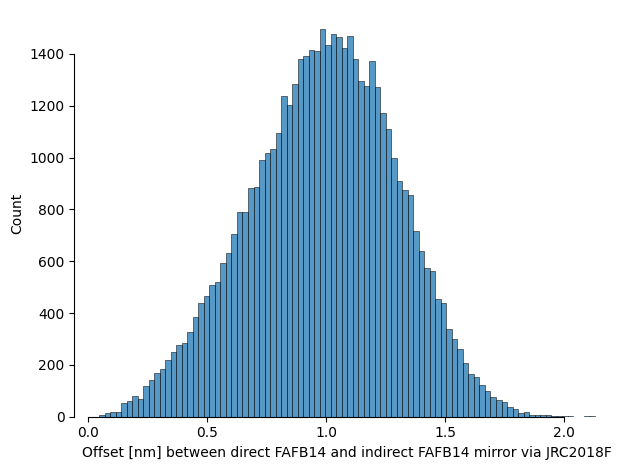

In [6]:
ax = sns.histplot(d)

ax.set_xlabel('Offset [nm] between direct FAFB14 and indirect FAFB14 mirror via JRC2018F')

sns.despine(trim=True)

plt.tight_layout()
plt.savefig('FAFB14_mirror_evaluation.png', dpi=450)